<h1> Introduction </h1>
<p>In this project, a web-scraping pipeline is setup for the purpose of extracting comments from popular subreddits from reddit.com. The pipe-line has knobs that are easy to tweak (and will become easier to do so). By default, the pipeline will go to the 50 current most trending subreddits, then for each subreddit, the comments of the top 5 current most trending individual posts will be extracted and saved. The code is setup in such a way that the 50 and 5 numbers can easily be changed (one can do just the 10 most trending subreddits and get the top 10 posts). One can also use a custom list of subreddits relatively easily. All data is saved automatically with a unique ID and timestamp</p>
<p> This project also uses the VADER sentiment analyzer to analyze the sentiment of the comments from each extracted subreddit. The VADER sentiment analyzer is a rule-based sentiment analyzer that can operate over unlabeled data (which is the case with the comment data). VADER has been proven effective at estimating sentiment in multiple studies, with results sometimes at 90% accurate in ceratin cases. Given the large sample of data, it is unlikely that a sentiment analyzer only 90% accurate, or even 80% accurate will significantly compromise the ability to extract any interesting insights from the data. Visualizations are also presented at the end comparing the sentiment scores of various subreddits, and the data matches intuitions one may have. </p>


In [3]:
import requests
from bs4 import BeautifulSoup
import re
import time
import numpy as np
import json
import pandas as pd
import os

<h1> Part 1: Scraping Data </h1>

In [4]:
def get_next_href(soup):
    """returns the ID of the next page of results from the current page"""
    match = ''
    for i in soup.find_all('a'):
        try:
            if 'https://old.reddit.com/r/all/?count=' in i['href']:
                match = i['href']
        except:
            pass #in case there's an a tag without an href
    return match

In [5]:
def get_top_subreddits():
    """returns a list of urls comprised of the 50 first unique subreddits appearing in r/all"""
    top_subreddits = []
    a = 0
    url = ''
    while len(top_subreddits)<50:
        if a == 0:
            url = 'https://old.reddit.com/r/all/'
        html = requests.get(url,headers = {'User-agent': 'your bot 0.1'})
        soup = BeautifulSoup(html.text)
        titles = soup.find_all('a',class_='subreddit hover may-blank')
        for i in titles:
            if i.text not in top_subreddits:
                top_subreddits.append(i.text)
            if len(top_subreddits) == 50:
                break
        url = get_next_href(soup)
        a +=1
        time.sleep(3)
    return top_subreddits

In [6]:
top_subreddits = get_top_subreddits()

In [7]:
len(top_subreddits) ##just checking things worked

50

In [8]:
def get_5_posts(url):
    """returns the urls of the current top 5 posts under a specific subreddit"""
    sub_urls = [] #urls of top 5 posts
    html = requests.get(url,headers = {'User-agent': 'your bot 0.1'})
    soup = BeautifulSoup(html.text)
    for i in range(5):
        sub_urls.append(soup.select('.first')[i].find('a')['href'])
    return sub_urls

In [9]:
#creating a dictionary with each top subreddit as a key, and a value of a dictionary containing each subreddit's
#top 5 posts
subreddit_dict = {}
for i in top_subreddits:
    subreddit_dict[i] = {'urls':get_5_posts('https://old.reddit.com/' + i)}

In [10]:
stop_phrases = ['[removed]','r/','www.']

In [11]:
def get_comment_sample_text(url):
    """gathers all the comments from an individual post"""
    html = requests.get(url,headers = {'User-agent': 'your bot 0.1'})
    soup = BeautifulSoup(html.text)
    html_text = soup.select('.md > p') #.md is the css class containing comments
    all_text = []
    for i in html_text[15:]: #selects all comments after the first 15 (as the first ones may be auto-generated)
        safe = True
        for phrase in stop_phrases:
            if phrase in i.text:
                safe = False
        if safe:
            all_text.append(i.text)
    return all_text

In [12]:
#places each comments of each subreddits top 5 posts into a large array and stores the array into the dictionary from
#earlier (subreddit dict)
for i in subreddit_dict.keys():
    subreddit_dict[i]['text'] = []
    for url in subreddit_dict[i]['urls']:
        subreddit_dict[i]['text'] += get_comment_sample_text(url)

In [13]:
def new_json_dir():
    """returns a unique name for a json file"""
    count = 0
    for d in os.listdir():
        if 'json' in d:
            count +=1
    return 'json'+str(count)

In [14]:
def save_dict_to_json():
    """creates a unique json file containing the dictionary containing all the subreddits names and comments"""
    json_dir = new_json_dir()
    os.mkdir(json_dir)
    with open(json_dir+'/test.json','w') as f:
        json.dump(subreddit_dict,f)

In [15]:
save_dict_to_json()

<h1>Part 2: Sentiment Analysis </h1>

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [17]:
sa = SentimentIntensityAnalyzer()
def make_big_string(arr):
    """converts an array of strings into one big string"""
    testtext= ''
    for i in arr:
        testtext += i
        testtext += ' '
    return testtext

In [18]:
#uses make_big_string to convert each subreddit's comment data into one big string, then uses VADER to analyze
#the sentiment of each subreddit's comment data and saves the scores into subreddit_dict
for i in subreddit_dict.keys():
    subreddit_dict[i]['polarity_scores'] = sa.polarity_scores(make_big_string(subreddit_dict[i]['text']))

In [19]:
#subtracts the positive scores from the negative scores to create a new metric
for i in subreddit_dict.keys():
    subreddit_dict[i]['polarity_scores']['pos_minus_neg'] = \
    round(subreddit_dict[i]['polarity_scores']['pos'] - subreddit_dict[i]['polarity_scores']['neg'],2)

In [20]:
def summary_statistics():
    list_keys = list(subreddit_dict.keys())
    first = list_keys[0]
    init = subreddit_dict[first]['polarity_scores']
    sum_stats = {'highest pos':[first, init['pos']],
                 'highest neg' : [first,init['neg']],
                 'highest neu': [first,init['neu']],
                 'highest pos_minus_neg': [first,init['pos_minus_neg']],
                 'lowest pos': [first,init['pos']],
                 'lowest neg': [first,init['neg']],
                 'lowest neu':[first,init['neu']],
                 'lowest pos_minus_neg': [first,init['pos_minus_neg']]}
    for key in list_keys[1:]:
        for i in sum_stats.keys():
            if 'highest' in i:
                if subreddit_dict[key]['polarity_scores'][i[8:]] > sum_stats[i][1]:
                    sum_stats[i][1] = subreddit_dict[key]['polarity_scores'][i[8:]]
                    sum_stats[i][0] = key
            elif 'lowest' in i:
                if subreddit_dict[key]['polarity_scores'][i[7:]] < sum_stats[i][1]:
                    sum_stats[i][1] = subreddit_dict[key]['polarity_scores'][i[7:]]
                    sum_stats[i][0] = key
    print(sum_stats)

In [21]:
summary_statistics()

{'highest pos': ['r/Art', 0.327], 'highest neg': ['r/SelfAwarewolves', 0.166], 'highest neu': ['r/space', 0.799], 'highest pos_minus_neg': ['r/Art', 0.28], 'lowest pos': ['r/news', 0.104], 'lowest neg': ['r/Art', 0.051], 'lowest neu': ['r/Art', 0.622], 'lowest pos_minus_neg': ['r/news', -0.06]}


In [22]:
#prepares data to be put into a dataframe containing each subreddit and it's polarity scores
to_df = []
for i in subreddit_dict.keys():
    to_append = []
    to_append.append(i)
    for stat in subreddit_dict[i]['polarity_scores']:
        to_append.append(subreddit_dict[i]['polarity_scores'][stat])
    to_df.append(to_append)

In [23]:
scores_df = pd.DataFrame(to_df,columns=['Subreddit','Neg','Neu','Pos','Compound','Pos Minus Neg'])

In [24]:
scores_df = scores_df.drop('Compound',axis=1)

In [25]:
scores_df['date_created'] = pd.to_datetime('now')

In [33]:
scores_df

,Subreddit,Neg,Neu,Pos,Pos Minus Neg,date_created
0,r/news,0.163,0.733,0.104,-0.06,2021-04-26 19:27:09.162658
1,r/nextfuckinglevel,0.080,0.715,0.205,0.12,2021-04-26 19:27:09.162658
2,r/WhitePeopleTwitter,0.128,0.763,0.109,-0.02,2021-04-26 19:27:09.162658
3,r/worldnews,0.108,0.764,0.128,0.02,2021-04-26 19:27:09.162658
4,r/interestingasfuck,0.112,0.711,0.177,0.06,2021-04-26 19:27:09.162658
5,r/leagueoflegends,0.102,0.715,0.183,0.08,2021-04-26 19:27:09.162658
6,r/pics,0.058,0.698,0.244,0.19,2021-04-26 19:27:09.162658
7,r/politics,0.124,0.738,0.138,0.01,2021-04-26 19:27:09.162658
8,r/wallstreetbets,0.100,0.744,0.157,0.06,2021-04-26 19:27:09.162658
9,r/MadeMeSmile,0.089,0.690,0.221,0.13,2021-04-26 19:27:09.162658


In [26]:
#functions for creating unique name a csv file to be saved with the subreddit scores
def get_unique_name():
    return 'unique_name' + str(len(os.listdir('scores'))) + '.csv'
def save_df(df):
    if 'scores' not in os.listdir():
        os.mkdir('scores')
    df.to_csv('scores/' + get_unique_name())

In [27]:
save_df(scores_df)

<h1>Part 3: Analysis and Visualizations </h1>

<AxesSubplot:ylabel='Subreddit'>

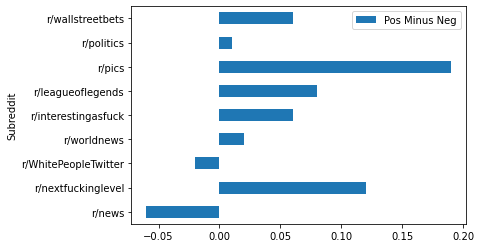

In [28]:
scores_df.iloc[0:9].plot.barh(x='Subreddit',y='Pos Minus Neg')

<AxesSubplot:ylabel='Subreddit'>

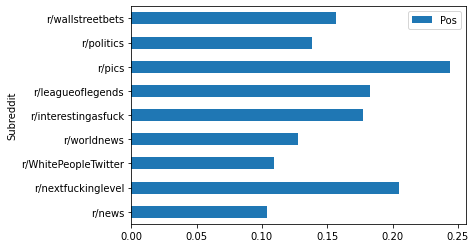

In [29]:
scores_df.iloc[0:9].plot.barh(x='Subreddit',y='Pos')

<AxesSubplot:ylabel='Subreddit'>

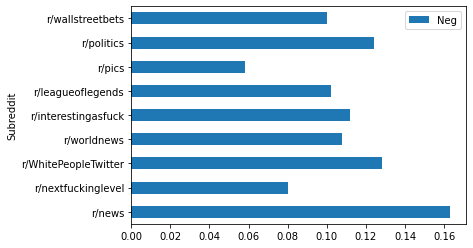

In [30]:
scores_df.iloc[0:9].plot.barh(x='Subreddit',y='Neg')